In [11]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, Dropout, Dense

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
 tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
train_path = 'train'
validation_path = 'val'
test_path = 'test'

def datagen_function(path, aug=False):
    if aug == True:
        generator = ImageDataGenerator(
            rescale = 1 / 255.0,
            rotation_range = 10,
            zoom_range = 0.1,
            horizontal_flip = True
        )
    else:
        generator = ImageDataGenerator(
            rescale = 1 / 255.0
        )
    return generator.flow_from_directory(
        path,
        target_size = (48,48),
        color_mode = 'rgb',
        shuffle = True,
        class_mode = 'categorical',
        batch_size = 64
    )

In [15]:
train_gen = datagen_function(train_path, True)
validation_gen = datagen_function(validation_path)
test_gen = datagen_function(test_path)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [16]:
# vgg-16 model definition
model = Sequential()

base_vgg16 = tf.keras.applications.VGG16(input_shape = (48,48,3), include_top= False, weights = 'imagenet')
base_vgg16.summary()
# base_vgg16.trainable = False

model.add(base_vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 5, min_lr = 0.000001, verbose = 1)
checkpoint = ModelCheckpoint('checkpoints/vgg16.h5', monitor='val_acc', save_best_only=True, save_freq="epoch")

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = 'acc', optimizer = optimizer)
history = model.fit(train_gen,validation_data = validation_gen, epochs = 100, callbacks = [reduce_lr, checkpoint])

Epoch 1/100
449/449 [==============================] - 42s 90ms/step - loss: 1.6469 - acc: 0.3483 - val_loss: 1.5732 - val_acc: 0.3962 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 40s 88ms/step - loss: 1.5728 - acc: 0.3868 - val_loss: 1.5496 - val_acc: 0.4023 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 40s 88ms/step - loss: 1.5403 - acc: 0.4014 - val_loss: 1.5327 - val_acc: 0.4107 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 39s 88ms/step - loss: 1.5243 - acc: 0.4085 - val_loss: 1.5312 - val_acc: 0.4051 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 40s 88ms/step - loss: 1.4989 - acc: 0.4208 - val_loss: 1.5186 - val_acc: 0.4280 - lr: 0.0010
Epoch 6/100
449/449 [==============================] - 39s 88ms/step - loss: 1.4868 - acc: 0.4267 - val_loss: 1.5181 - val_acc: 0.4188 - lr: 0.0010
Epoch 7/100
449/449 [==============================] - 40s 88ms/step - loss: 1.4742 - acc: 0.4312 - val_loss: 1.

In [9]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_acc', mode='max', factor = 0.5, patience = 10, min_lr = 0.000001, verbose = 1)

In [17]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics= 'acc')
history = model.fit(train_gen,validation_data = validation_gen, epochs = 100, callbacks = [reduce_lr2, checkpoint])

Epoch 1/100
449/449 [==============================] - 51s 106ms/step - loss: 1.3828 - acc: 0.4683 - val_loss: 1.1913 - val_acc: 0.5442 - lr: 0.0100
Epoch 2/100
449/449 [==============================] - 44s 98ms/step - loss: 1.1402 - acc: 0.5710 - val_loss: 1.0904 - val_acc: 0.5890 - lr: 0.0100
Epoch 3/100
449/449 [==============================] - 44s 98ms/step - loss: 1.0494 - acc: 0.6064 - val_loss: 1.0958 - val_acc: 0.5918 - lr: 0.0100
Epoch 4/100
449/449 [==============================] - 44s 98ms/step - loss: 0.9857 - acc: 0.6299 - val_loss: 1.0383 - val_acc: 0.6177 - lr: 0.0100
Epoch 5/100
449/449 [==============================] - 43s 96ms/step - loss: 0.9378 - acc: 0.6503 - val_loss: 1.0371 - val_acc: 0.6169 - lr: 0.0100
Epoch 6/100
449/449 [==============================] - 44s 98ms/step - loss: 0.8949 - acc: 0.6674 - val_loss: 0.9773 - val_acc: 0.6278 - lr: 0.0100
Epoch 7/100
449/449 [==============================] - 44s 98ms/step - loss: 0.8507 - acc: 0.6866 - val_loss: 0

In [20]:
model = load_model('checkpoints/vgg16.h5')

In [21]:
model.evaluate(test_gen,verbose=1)

57/57 [==============================] - 2s 31ms/step - loss: 2.2336 - acc: 0.6924


[2.2335641384124756, 0.69239342212677]

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


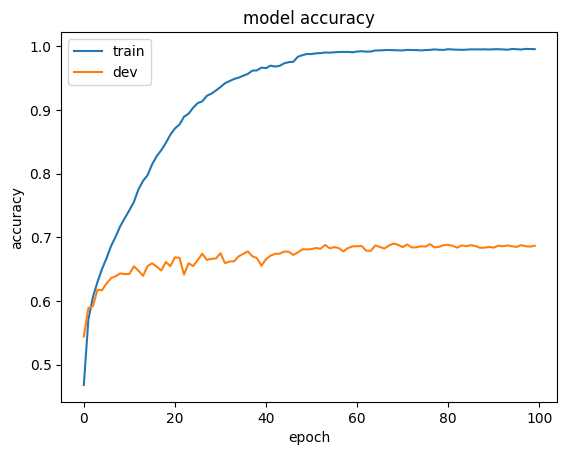

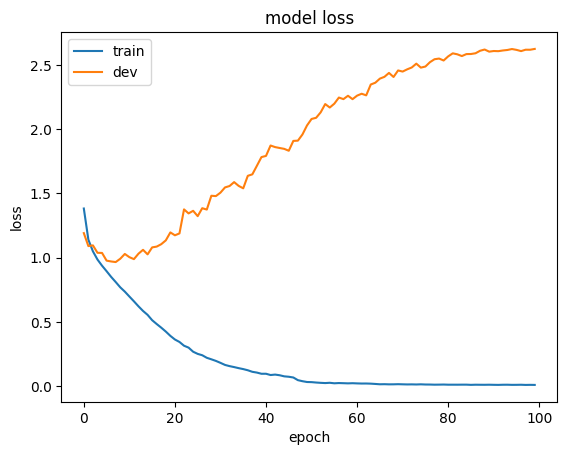

In [23]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [24]:
model_updated = Sequential()

base_vgg16 = tf.keras.applications.VGG16(input_shape = (48,48,3), include_top= False, weights = 'imagenet')
base_vgg16.summary()
# base_vgg16.trainable = False

model_updated.add(base_vgg16)
model_updated.add(Flatten())

model_updated.add(Dense(4096, activation='relu'))
model_updated.add(Dropout(0.4))
model_updated.add(Dense(1024, activation='relu'))
model_updated.add(Dropout(0.4))
model_updated.add(Dense(7, activation='softmax'))

model_updated.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)

checkpoint = ModelCheckpoint('checkpoints/vgg16.h5', monitor='val_acc', save_best_only=True, save_freq="epoch")
reduce_lr2 = ReduceLROnPlateau(monitor='val_acc', mode='max', factor = 0.5, patience = 10, min_lr = 0.000001, verbose = 1)

model_updated.compile(optimizer=sgd, loss='categorical_crossentropy', metrics= 'acc')
history = model_updated.fit(train_gen,validation_data = validation_gen, epochs = 100, callbacks = [reduce_lr2, checkpoint])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [25]:
model = load_model('checkpoints/vgg16.h5')

In [26]:
model.evaluate(test_gen,verbose=1)

57/57 [==============================] - 2s 31ms/step - loss: 2.3836 - acc: 0.7038


[2.3836257457733154, 0.7038172483444214]

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


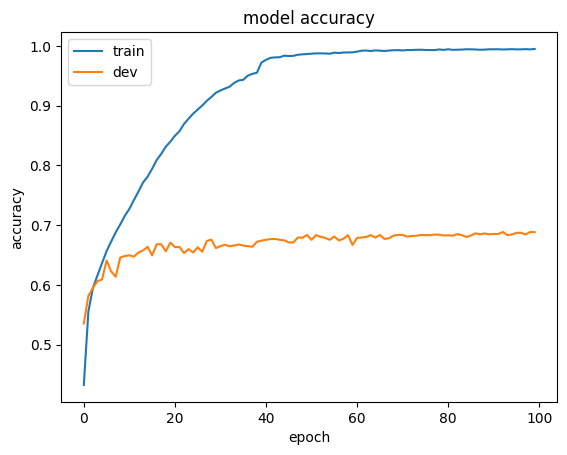

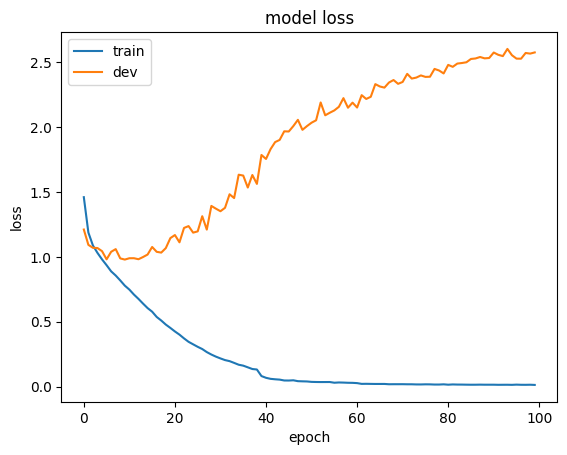

In [27]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()